# Lab3 Classification and Regression

This week's exercise will be a bit shorter. The objective is to implement the core of the k-nn algorithm (most of the pre-processing and evaluation is given), followed by a Q&A moment

Schedule:
* Classify data using k-neighbors
* Use a confusion matrix to evluate models
* Q&A on the last lectures

## Reminders
* [GitHub repo](https://github.com/Faur/ITU-Data-Science-in-Games-Exercises)
* **Shut down notebooks** when you are done. Otherwise the server will run out of resources, and we will be forced to restart the them.
* Server storage is volatile! I.e. you must **save everything locally** that you don't want to loose.

In [1]:
# ! git pull

In [2]:
# Makes matplotlib plots work better with Jupyter
%matplotlib inline

# Import the necessary libraries. 
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

## Take a look at the data

In [3]:
# Check that data and data path is present
basedir = "../"
file = "fifa.csv"
assert os.path.isdir(f"{basedir}data") and os.path.exists(f"{basedir}data/{file}"), 'Data not found. Make sure to have the most recent version!'

data = pd.read_csv(f'{basedir}/data/fifa.csv', sep=",")

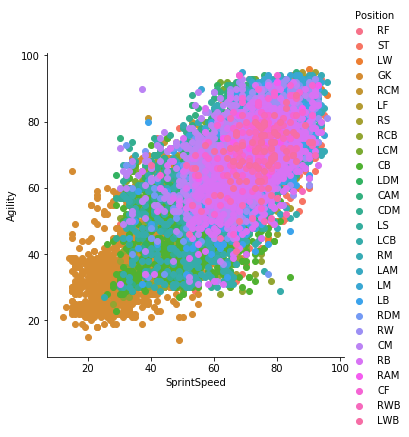

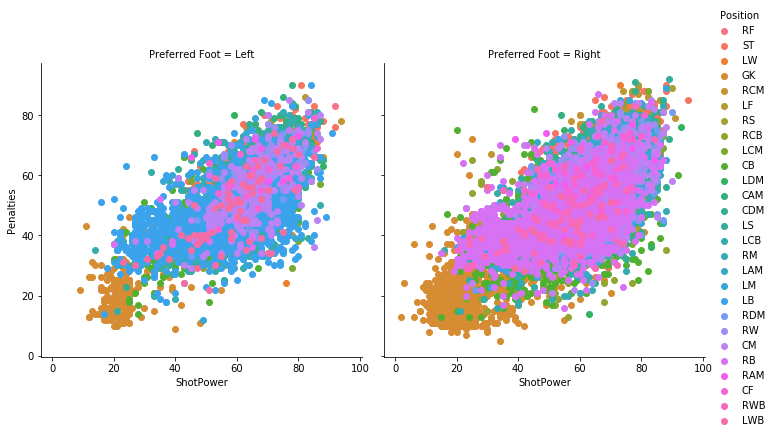

In [4]:
sns.FacetGrid(data, height=5,hue="Position").map(plt.scatter,"SprintSpeed","Agility").add_legend()
sns.FacetGrid(data, height=5,hue="Position", col='Preferred Foot').map(plt.scatter,"ShotPower",'Penalties').add_legend()

The scatter plots shows that the `Position` of a player could be related to some of their statistics. The dataset contains 30+ statistics and we don't know which ones will be most helpful, so we are picking an arbitrary subset to avoid the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).
It's also possible to choose the best ones [algorithmically](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Feature_extraction)

In [5]:
all_features = ['Crossing','Finishing','HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve','FKAccuracy','LongPassing',
            'BallControl','Acceleration','SprintSpeed','Agility','Reactions','Balance','ShotPower','Jumping','Stamina',
            'Strength','LongShots','Aggression','Interceptions','Positioning','Vision','Penalties','Composure',
            'Marking','StandingTackle','SlidingTackle','GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes']

features = ["SprintSpeed","Agility","ShotPower",'Penalties']
# cleaning: remove all the lines that contain a NaN in one of the feature columns
data = data.dropna(subset=features)

# Classification problem

0. pick a value for K (number of clusters) and N (number of neighbors)
1. split the data in train and validation set
2. normalize fields (in our case the data are already normalized)
3. foreach `datapoint` in `validation set`:
  1. find the N nearest neighbors
  2. set as label of `datapoint` the label that appears most between its neighbors

In [6]:
# 0: define and N
K = 17

Choose the right K can be tricky. As usual, [stand on the shoulder of giants](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Parameter_selection)

# Step-by-step implemntation

In [8]:
# 3.1: let's start with calculating the Euclidean distance from a single datapoint to all the other

knn_classification = lambda x, class_col, train_set: (
                                train_set[features].sub(x[features])
                               .pow(2).sum(1).pow(0.5)
                            )

# the first row of the result should be 0, since we are calculating the distance between a point and itself
# check pandas API for iloc[] if necessary
knn_classification(data.iloc[0], 'Position', data)

0          0.000000
1         15.524175
2         10.099505
3         76.720271
4         17.204651
5         12.247449
6         16.881943
7         17.406895
8         18.055470
9         96.524608
10        20.273135
11        32.015621
12        48.600412
13        25.573424
14        27.964263
15        11.789826
16        28.809721
17         6.557439
18       103.348924
19        82.225300
20        50.813384
21        20.000000
22        81.608823
23        11.575837
24        46.518813
25        12.727922
26        16.881943
27        36.932371
28        21.494185
29        17.464249
            ...    
18177     66.249528
18178    124.887950
18179     84.782074
18180     98.833193
18181     77.110311
18182     70.753092
18183    122.531629
18184     69.892775
18185     63.859220
18186     57.662813
18187     59.749477
18188     65.642974
18189     62.561969
18190     90.432295
18191     89.716219
18192     72.972598
18193     88.870693
18194    123.846679
18195     68.585713


In [9]:
# 3.2: to implement k-nn, we need the K closest neighbors. We'll get them with a pandas funciton,
# for convenience and performance

knn_classification = lambda x, class_col, train_set: (train_set[features].sub(x[features])
                               .pow(2).sum(1).pow(0.5)
                               .nsmallest(K)
                               )

knn_classification(data.iloc[0], 'Position', data)

0       0.000000
173     3.464102
138     3.605551
893     5.291503
258     5.477226
750     5.830952
286     6.244998
155     6.403124
17      6.557439
599     6.708204
267     6.782330
256     7.000000
157     7.071068
1585    7.071068
50      7.141428
170     7.141428
84      7.280110
dtype: float64

In [10]:
# 3.3: from here, we need the labels associated to this rows. The result is still referencing to our original dataset
# (the left column is the index on the original dataset), so we can use iloc[] as before for this

# let's also move everything we did up until now in a different function
nearest_neighbors = lambda x, train_set: (train_set[features].sub(x[features])
                               .pow(2).sum(1).pow(0.5)
                               .nsmallest(K)
                               ).index # IMPORTANT: .index was missing in the lab (see next cell)


knn_classification = lambda x, class_col, train_set: (
    # IMPORTANT: .loc[] instead of .iloc[] (see next cell)
    train_set.loc[nearest_neighbors(x, train_set)]
)


knn_classification(data.iloc[0], 'Position', data)

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
173,173,208418,Y. Carrasco,24,https://cdn.sofifa.org/players/4/19/208418.png,Belgium,https://cdn.sofifa.org/flags/7.png,83,86,Dalian YiFang FC,...,75.0,58.0,39.0,26.0,9.0,11.0,9.0,10.0,10.0,€73.4M
138,138,183898,A. Di María,30,https://cdn.sofifa.org/players/4/19/183898.png,Argentina,https://cdn.sofifa.org/flags/52.png,84,84,Paris Saint-Germain,...,82.0,35.0,59.0,56.0,10.0,7.0,11.0,12.0,11.0,€54.6M
893,893,184575,R. Alessandrini,29,https://cdn.sofifa.org/players/4/19/184575.png,France,https://cdn.sofifa.org/flags/18.png,78,78,LA Galaxy,...,77.0,53.0,55.0,34.0,11.0,12.0,9.0,16.0,9.0,€15M
258,258,203551,A. Florenzi,27,https://cdn.sofifa.org/players/4/19/203551.png,Italy,https://cdn.sofifa.org/flags/27.png,82,83,Roma,...,79.0,76.0,79.0,78.0,9.0,8.0,10.0,11.0,10.0,€36.4M
750,750,226377,G. Martínez,25,https://cdn.sofifa.org/players/4/19/226377.png,Argentina,https://cdn.sofifa.org/flags/52.png,78,82,River Plate,...,77.0,41.0,28.0,30.0,6.0,9.0,13.0,12.0,15.0,€19.9M
286,286,188803,Taison,30,https://cdn.sofifa.org/players/4/19/188803.png,Brazil,https://cdn.sofifa.org/flags/54.png,82,82,Shakhtar Donetsk,...,74.0,38.0,53.0,40.0,7.0,7.0,11.0,15.0,13.0,€44.1M
155,155,231443,O. Dembélé,21,https://cdn.sofifa.org/players/4/19/231443.png,France,https://cdn.sofifa.org/flags/18.png,83,92,FC Barcelona,...,75.0,42.0,30.0,33.0,6.0,6.0,14.0,10.0,13.0,€90M
17,17,194765,A. Griezmann,27,https://cdn.sofifa.org/players/4/19/194765.png,France,https://cdn.sofifa.org/flags/18.png,89,90,Atlético Madrid,...,87.0,59.0,47.0,48.0,14.0,8.0,14.0,13.0,14.0,€165.8M
599,599,211368,Bruma,23,https://cdn.sofifa.org/players/4/19/211368.png,Portugal,https://cdn.sofifa.org/flags/38.png,79,83,RB Leipzig,...,72.0,26.0,27.0,28.0,11.0,13.0,8.0,12.0,8.0,€29.3M


In [16]:
# 3.4: now that we have the neigbors, lets get their labels and select the one that appear more times
nearest_neighbors = lambda x, train_set: (train_set[features].sub(x[features])
                               .pow(2).sum(1).pow(0.5)
                               .nsmallest(K)
                               ).index # IMPORTANT: .index was missing in the lab (see next cell)


knn_classification = lambda x, class_col, train_set: (
    # IMPORTANT: .loc[] instead of .iloc[] (see next cell)
    train_set.loc[nearest_neighbors(x, train_set)]
        [class_col]
        .mode()
)

# this time we are using a different datapoint, it will show us a problem
knn_classification(data.iloc[6], 'Position', data)

0     LM
1    RCM
2     RW
dtype: object

# Correction from the Lab. code

During the lab, `iloc[]` has been used insted of `loc[]`. They seems similar but actually they are QUITE different:
- `loc[i]` returns the row with index `i`
- `iloc[i]` returns the row in the `i`-th position

When creating a dataset (unless directly specified), the index of a row is just in position, so both functions will return the same row. That doesn't hold true after manipulating the DataFrame (eg, cleaning, sorting, etc).

The correct way to reference a dataset using the entries of a DataFrame `a` from the entries af another DataFrame `b` is:
```
a.loc[b.index]
```

In [17]:
# 3.5: some of the modes that we will calculate will return more than one value. This won't work,
#      so we need to pick one of them. The best solution would be to assign a weight to each neighbor
#      based on its distance (see lecture's slides), sum the weights grouped by label and pick the label
#      with the highest score. You can try that or ask us for examples. Here we'll use the first entry,
#      even if this will degrade our performance (possubly by quite a lot)

nearest_neighbors = lambda x, train_set: (train_set[features].sub(x[features])
                               .pow(2).sum(1).pow(0.5)
                               .nsmallest(K)
                               ).index # IMPORTANT: .index was missing in the lab (see next cell)


knn_classification = lambda x, class_col, train_set: (
    # IMPORTANT: .loc[] instead of .iloc[] (see next cell)
    train_set.loc[nearest_neighbors(x, train_set)]
        [class_col]
        .mode()[0]
)


knn_classification(data.iloc[6], 'Position', data)

'LM'

In [18]:
def classify(dataset, class_col, random_state=None, frac=0.995):
    # 1: random split. It's always a good idea (maybe the dataset is sorted, and so on).
    # random_state that you to always get the same split (useful for testing). Check docs
    train_set = data.sample(frac=frac, random_state=random_state)
    valid_set = data.drop(train_set.index)

    classified_set = valid_set
    classified_set[f'Calculated {class_col}'] = valid_set.apply(
        lambda x: knn_classification(x, class_col, train_set),
        axis=1
    )
    return classified_set

classified_position = classify(data, 'Position')[['Position', 'Calculated Position']]
classified_position

,Position,Calculated Position
115,CB,LCB
196,GK,GK
352,LB,RB
611,CDM,LCM
735,RB,CAM
1038,RB,LB
1148,LWB,LM
1294,GK,GK
1296,ST,LM
1429,RCB,CB


# Binary classification with positive class
In many cases, it's important to determine if a datapoint belongs or not to a certain class or not and the distribution is skewed (poisonus/not poisonus, cancer/not cancer, ...)

In [13]:
K = 3

data['Goalkeeper'] = data['Position'] == 'GK'

classified_goalkeeper = classify(data, 'Goalkeeper', frac=0.99)[['Goalkeeper', 'Calculated Goalkeeper']]

C:\Users\Chris\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Classification evaluation

1. generate confusion matrix
2. evaluate the classification

In [14]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig


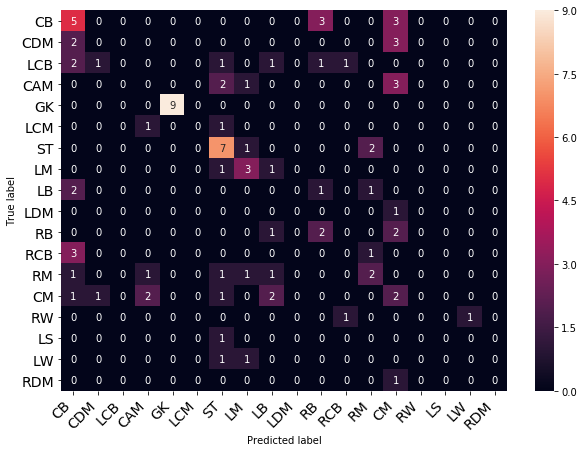

Precision: 0.32967032967032966


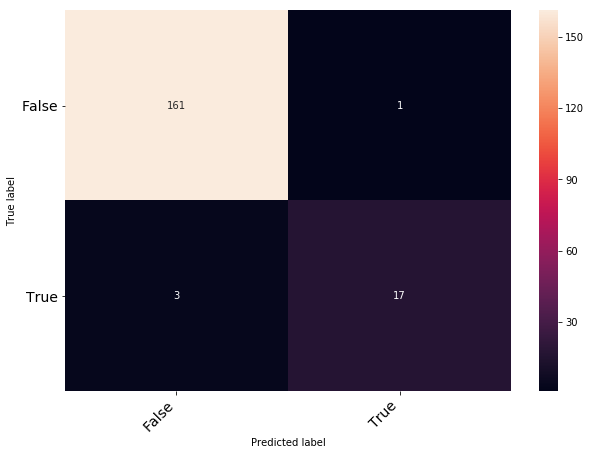

[161   1   3  17]
Accuracy: 0.978021978021978
Error rate: 0.02197802197802198
Sensitivity: 0.9444444444444444
Specificity: 0.9817073170731707
Precision: 0.9817073170731707


In [15]:
def print_results(data, class_col, binary=False):
    labels = data[class_col].unique()
    cm = confusion_matrix(data[class_col], data[f'Calculated {class_col}'], labels=labels)

    print_confusion_matrix(
        cm,
        labels
    )
    plt.show()  # wait for the render (otherwise it will print the graphs async, after the strings)
    
    if binary:
        tn, fp, fn, tp = cm.ravel()

        accuracy = (tp + tn) / (tn + fp + fn + tp)
        err_rate = (fp + fn) / (tn + fp + fn + tp)
        sensitiv = (tp) / (fp + tp)
        specific = (tn) / (tn + fn)
        precision = (tp) / (tp + tn)

        print(cm.ravel())
        print(f'Accuracy: {accuracy}')
        print(f'Error rate: {err_rate}')
        print(f'Sensitivity: {sensitiv}')
        print(f'Specificity: {specific}')
        print(f'Precision: {specific}')
    else:
        diag = [cm[i][i] for i in range(len(cm))]        
        rows = [sum(cm[i]) for i in range(len(cm))]
        
        right_pred = sum(diag)
        wrong_pred = sum(rows)
        
        print(f'Precision: {right_pred / wrong_pred}')
    
        
    
    
print_results(classified_position, 'Position')
print_results(classified_goalkeeper, 'Goalkeeper', binary=True)

The accuracy seems high for the `Goalkeeper` class, but because the percentage of goalkeepers is low. In those cases, Snsitivity is a much better metric. Here will probably be very low because the metric are chosen arbitrarly. You can check the link above to see how to pick appropriate dimensions.

Additionally, for skewed distributions:
> A drawback of the basic "majority voting" classification occurs when the class distribution is skewed. That is, examples of a more frequent class tend to dominate the prediction of the new example, because they tend to be common among the k nearest neighbors due to their large number[[4]](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#cite_note-Coomans_Massart1982-4). One way to overcome this problem is to weight the classification, taking into account the distance from the test point to each of its k nearest neighbors. The class (or value, in regression problems) of each of the k nearest points is multiplied by a weight proportional to the inverse of the distance from that point to the test point